In [1]:
%load_ext autoreload
%autoreload 2

In [5]:
import os
import numpy as np
from src import config

In [13]:
from src.training import _load_features, _load_labels, _remove_duplicate_labels

AttributeError: partially initialized module 'pandas' has no attribute 'core' (most likely due to a circular import)

In [4]:
%cd /home/marco/speaker_identification
features = _load_features(first_n_files=4)

/home/marco/speaker_identification


In [18]:
df_labels = _load_labels()
df_labels = _remove_duplicate_labels(df_labels)

In [19]:
labels

,filename,label_date,label_time,label
0,PTT-20200113-WA0016,20220824,101700,Person 1
1,PTT-20200116-WA0000,20220824,101730,Person 2
2,PTT-20200117-WA0007,20220824,101800,Person 2
3,PTT-20200119-WA0013,20220824,101830,Person 1


In [7]:
from matplotlib import pyplot as plt

In [9]:
# Return the (g,h) index of the BMU in the grid
def find_BMU(SOM, x):
    distSq = (np.square(SOM - x)).sum(axis=2)
    return np.unravel_index(np.argmin(distSq, axis=None), distSq.shape)
    
# Update the weights of the SOM cells when given a single training example
# and the model parameters along with BMU coordinates as a tuple
def update_weights(SOM, train_ex, learn_rate, radius_sq, 
                   BMU_coord, step=3):
    g, h = BMU_coord
    #if radius is close to zero then only BMU is changed
    if radius_sq < 1e-3:
        SOM[g,h,:] += learn_rate * (train_ex - SOM[g,h,:])
        return SOM
    # Change all cells in a small neighborhood of BMU
    for i in range(max(0, g-step), min(SOM.shape[0], g+step)):
        for j in range(max(0, h-step), min(SOM.shape[1], h+step)):
            dist_sq = np.square(i - g) + np.square(j - h)
            dist_func = np.exp(-dist_sq / 2 / radius_sq)
            SOM[i,j,:] += learn_rate * dist_func * (train_ex - SOM[i,j,:])   
    return SOM    

# Main routine for training an SOM. It requires an initialized SOM grid
# or a partially trained grid as parameter
def train_SOM(SOM, train_data, learn_rate = .1, radius_sq = 1, 
             lr_decay = .1, radius_decay = .1, epochs = 10):    
    learn_rate_0 = learn_rate
    radius_0 = radius_sq
    for epoch in np.arange(0, epochs):
        rand.shuffle(train_data)      
        for train_ex in train_data:
            g, h = find_BMU(SOM, train_ex)
            SOM = update_weights(SOM, train_ex, 
                                 learn_rate, radius_sq, (g,h))
        # Update learning rate and radius
        learn_rate = learn_rate_0 * np.exp(-epoch * lr_decay)
        radius_sq = radius_0 * np.exp(-epoch * radius_decay)            
    return SOM

In [10]:
# Dimensions of the SOM grid
m = 10
n = 10
dim = 3
# Number of training examples
n_x = 3000
rand = np.random.RandomState(0)
# Initialize the training data
train_data = rand.randint(0, 255, (n_x, dim))

train_data

array([[172,  47, 117],
       [192,  67, 251],
       [195, 103,   9],
       ...,
       [173,  62,  10],
       [ 94,  96, 213],
       [104,  54,  94]])

In [11]:
SOM = rand.randint(0, 255, (m, n, dim)).astype(float)

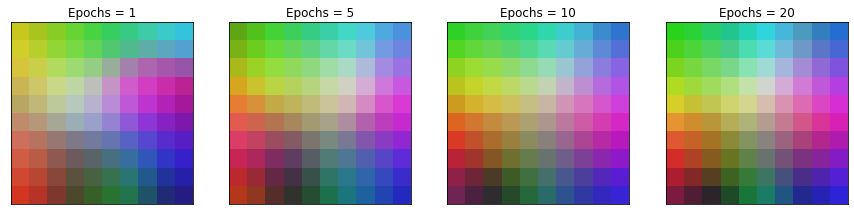

In [12]:
fig, ax = plt.subplots(
    nrows=1, ncols=4, figsize=(15, 3.5), 
    subplot_kw=dict(xticks=[], yticks=[]))
total_epochs = 0
for epochs, i in zip([1, 4, 5, 10], range(0,4)):
    total_epochs += epochs
    SOM = train_SOM(SOM, train_data, epochs=epochs)
    ax[i].imshow(SOM.astype(int))
    ax[i].title.set_text('Epochs = ' + str(total_epochs))